# **Dịch máy Anh-Pháp với mô hình Encoder-Decoder sử dụng attention và beam search**

## 1. Chuẩn bị vấn đề

### 1.1. Import các thư viện cần thiết
Các yêu cầu hệ thống:
- Python phiên bản 3.10.18
- Pytorch phiên bản 2.1.0 (có hỗ trợ CUDA)
- Torchtext phiên bản 0.16.0
- NLTK phiên bản 3.9.1
- Numpy phiên bản 1.26.4
- Matplotlib phiên bản 3.10.6
- Pandas phiên bản 2.3.3

In [76]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
import random, copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, PackedSequence
from torch.utils.data import DataLoader
from torchtext.vocab import build_vocab_from_iterator
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt

### 1.2. Chọn thiết bị làm việc trên Pytorch

In [77]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Kiểm tra liên kết thiết bị
if DEVICE.type == 'cuda':
    print("CUDA is available.")
    print("Device name:", torch.cuda.get_device_name(0))
    print("CUDA version:", torch.version.cuda)
else:
    print("CUDA is not available, using CPU.")

CUDA is available.
Device name: NVIDIA GeForce RTX 3050 Laptop GPU
CUDA version: 12.1


### 1.3. Thiết lập random seed ngẫu nhiên để bảo đảm tính tái tạo
Chạy command này trên CommandPrompt trước khi chạy chương trình: __set CUBLAS_WORKSPACE_CONFIG=:4096:8__. Tắt bằng __set CUBLAS_WORKSPACE_CONFIG=__

In [78]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


SEED = 42
set_seed(SEED)

# Dataloader deterministic
g = torch.Generator()
g.manual_seed(SEED)

rng = torch.Generator()
rng.manual_seed(SEED)

## 2. Chuẩn bị dữ liệu và xử lý dữ liệu

### 2.1. Tải dữ liệu train, validation, test

In [79]:
def load_lines(path):
    with open(path, 'r', encoding='utf-8') as f:
        return [l.strip() for l in f if l.strip()]
    
train_en = load_lines("./data/train.en")
train_fr = load_lines("./data/train.fr")
val_en   = load_lines("./data/val.en")
val_fr   = load_lines("./data/val.fr")
test_en  = load_lines("./data/test.en")
test_fr  = load_lines("./data/test.fr")

In [80]:
# kiểm tra dữ liệu
print("Train EN: ", train_en[1:10])
print("Train FR: ", train_fr[1:10])
print("Validation EN: ", val_en[1:10])
print("Validation FR: ", val_fr[1:10])
print("Test EN: ", test_en[1:10])
print("Test FR: ", test_fr[1:10])

Train EN:  ['Several men in hard hats are operating a giant pulley system.', 'A little girl climbing into a wooden playhouse.', 'A man in a blue shirt is standing on a ladder cleaning a window.', 'Two men are at the stove preparing food.', 'A man in green holds a guitar while the other man observes his shirt.', 'A man is smiling at a stuffed lion', 'A trendy girl talking on her cellphone while gliding slowly down the street.', 'A woman with a large purse is walking by a gate.', 'Boys dancing on poles in the middle of the night.']
Train FR:  ['Plusieurs hommes en casque font fonctionner un système de poulies géant.', 'Une petite fille grimpe dans une maisonnette en bois.', 'Un homme dans une chemise bleue se tient sur une échelle pour nettoyer une fenêtre.', 'Deux hommes aux fourneaux préparent à manger.', "Un homme en vert tient une guitare tandis qu'un autre homme observe sa chemise.", 'Un homme sourit à un ours en peluche.', 'Une fille branchée parle à son portable tout en glissant l

### 2.2. Tokenization
Thực hiện chuyển các câu thành danh sách token dùng tokenizer của spacy

In [81]:
PAD_TOK = "<pad>"
UNK_TOK = "<unk>"
SOS_TOK = "<sos>"
EOS_TOK = "<eos>"

In [82]:
# Hàm tokenizer
def tokenize(s):
    return s.lower().strip().split()

# Hàm thêm token <sos> ở đầu chuỗi và <eos> ở cuối chuỗi
def add_sos_eos(toks):
    return [SOS_TOK] + toks + [EOS_TOK]

In [83]:
train_en_tok = [add_sos_eos(tokenize(s)) for s in train_en]
train_fr_tok = [add_sos_eos(tokenize(s)) for s in train_fr]
val_en_tok   = [add_sos_eos(tokenize(s)) for s in val_en]
val_fr_tok   = [add_sos_eos(tokenize(s)) for s in val_fr]
test_en_tok  = [add_sos_eos(tokenize(s)) for s in test_en]
test_fr_tok  = [add_sos_eos(tokenize(s)) for s in test_fr]

In [84]:
# Kiểm tra
print("Train EN (tokenized): ", train_en_tok[1:10])
print("Train FR (tokenized): ", train_fr_tok[1:10])
print("Validation EN (tokenized): ", val_en_tok[1:10])
print("Validation FR (tokenized): ", val_fr_tok[1:10])
print("Test EN (tokenized): ", test_en_tok[1:10])
print("Test FR (tokenized): ", test_fr_tok[1:10])

Train EN (tokenized):  [['<sos>', 'several', 'men', 'in', 'hard', 'hats', 'are', 'operating', 'a', 'giant', 'pulley', 'system.', '<eos>'], ['<sos>', 'a', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse.', '<eos>'], ['<sos>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window.', '<eos>'], ['<sos>', 'two', 'men', 'are', 'at', 'the', 'stove', 'preparing', 'food.', '<eos>'], ['<sos>', 'a', 'man', 'in', 'green', 'holds', 'a', 'guitar', 'while', 'the', 'other', 'man', 'observes', 'his', 'shirt.', '<eos>'], ['<sos>', 'a', 'man', 'is', 'smiling', 'at', 'a', 'stuffed', 'lion', '<eos>'], ['<sos>', 'a', 'trendy', 'girl', 'talking', 'on', 'her', 'cellphone', 'while', 'gliding', 'slowly', 'down', 'the', 'street.', '<eos>'], ['<sos>', 'a', 'woman', 'with', 'a', 'large', 'purse', 'is', 'walking', 'by', 'a', 'gate.', '<eos>'], ['<sos>', 'boys', 'dancing', 'on', 'poles', 'in', 'the', 'middle', 'of', 'the', 'night.', '<eos>']]
Train FR

### 2.3. Xây dựng từ điển
Xây dựng từ điển dùng build_vocal_from_iterator của pytorchtext với các token đặc biệt là $<unk>, <pad>, <sos>, <eos>$ và giới hạn 10000 từ phổ biến nhất

In [85]:
MAX_VOCAB = 10000


vocab_en = build_vocab_from_iterator(iter(train_en_tok),
                                     specials=[UNK_TOK, PAD_TOK, SOS_TOK, EOS_TOK],
                                     max_tokens=MAX_VOCAB)
vocab_fr = build_vocab_from_iterator(iter(train_fr_tok),
                                     specials=[UNK_TOK, PAD_TOK, SOS_TOK, EOS_TOK],
                                     max_tokens=MAX_VOCAB)

# Đặt index mặc định là <unk>
vocab_en.set_default_index(vocab_en[UNK_TOK])
vocab_fr.set_default_index(vocab_fr[UNK_TOK])

In [86]:
# Kiểm tra 
print("Vocab EN (first 20 words): ", vocab_en.get_itos()[:20])
print("Vocab FR (first 20 words): ", vocab_fr.get_itos()[:20])

Vocab EN (first 20 words):  ['<unk>', '<pad>', '<sos>', '<eos>', 'a', 'in', 'the', 'on', 'man', 'is', 'and', 'of', 'with', 'two', 'woman', 'are', 'to', 'at', 'people', 'an']
Vocab FR (first 20 words):  ['<unk>', '<pad>', '<sos>', '<eos>', 'un', 'une', 'de', 'en', 'dans', 'sur', 'homme', 'et', 'des', 'avec', 'la', 'à', 'femme', 'deux', 'le', "d'un"]


### 2.4. Xây dựng tensor
Thực hiện chuyển đổi dữ liệu từ dạng chuỗi sang dạng tensor.

In [87]:
# Hàm chuyển đổi từ token sang tensor
def tokToTensor(toks, vocab):
    return torch.tensor([vocab[t] for t in toks], dtype=torch.long)

train_en_t = [tokToTensor(t, vocab_en) for t in train_en_tok]
train_fr_t = [tokToTensor(t, vocab_fr) for t in train_fr_tok]
val_en_t   = [tokToTensor(t, vocab_en) for t in val_en_tok]
val_fr_t   = [tokToTensor(t, vocab_fr) for t in val_fr_tok]
test_en_t  = [tokToTensor(t, vocab_en) for t in test_en_tok]
test_fr_t  = [tokToTensor(t, vocab_fr) for t in test_fr_tok]

# Lấy ra index của các token <pad>, <sos>, <eos>, <unk>
PAD_EN = vocab_en[PAD_TOK]
PAD_FR = vocab_fr[PAD_TOK]
SOS_EN = vocab_en[SOS_TOK]
SOS_FR = vocab_fr[SOS_TOK]
EOS_EN = vocab_en[EOS_TOK]
EOS_FR = vocab_fr[EOS_TOK]
UNK_EN = vocab_en[UNK_TOK]
UNK_FR = vocab_fr[UNK_TOK]

### 2.5. Đóng gói dữ liệu
Chuẩn bị dữ liệu bằng cách đóng gói theo batch, padding và sắp xếp theo độ dài giảm dần

In [88]:
BATCH = 64

# Hàm collate 
def collate_fn(batch):
    ens = [x[0] for x in batch]
    frs = [x[1] for x in batch]

    # Padding
    pad_en = pad_sequence(ens, batch_first=True, padding_value=PAD_EN)
    pad_fr = pad_sequence(frs, batch_first=True, padding_value=PAD_FR)

    # Length của src
    len_en = (pad_en != PAD_EN).sum(dim=1)

    # Sort theo length giảm dần
    len_en_sorted, indices = torch.sort(len_en, descending=True)

    pad_en = pad_en[indices]
    pad_fr = pad_fr[indices]

    # Packing
    packed_src = pack_padded_sequence(
        pad_en, 
        len_en_sorted.cpu(),
        batch_first=True,
        enforce_sorted=True 
    )

    return packed_src, pad_fr, len_en_sorted


# Gom dữ liệu thành 2 tập train và test
train_data = list(zip(train_en_t, train_fr_t))
val_data   = list(zip(val_en_t, val_fr_t))

# Đóng gói bằng cách tạo dataLoader
train_loader = DataLoader(
    train_data, batch_size=BATCH, shuffle=True,
    collate_fn=collate_fn, generator=g
)
val_loader = DataLoader(
    val_data, batch_size=BATCH, shuffle=False,
    collate_fn=collate_fn, generator=g
)

### 3.1. Thiết lập Luong attention

In [89]:
class LuongAttention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.attn = nn.Linear(hidden_size, hidden_size, bias=False)

    def forward(self, dec_hidden, enc_outputs, src_mask=None):
        # (B, 1, H)
        dec_hidden = dec_hidden.unsqueeze(1)

        # (B, T, H)
        enc_transformed = self.attn(enc_outputs)

        # score
        scores = torch.bmm(dec_hidden, enc_transformed.transpose(1, 2))
        scores = scores.squeeze(1)   # (B, T)

        if src_mask is not None:
            scores = scores.masked_fill(src_mask == 0, -1e9)

        attn_weights = torch.softmax(scores, dim=1)  # (B, T)

        # context 
        context = torch.bmm(attn_weights.unsqueeze(1), enc_outputs)
        context = context.squeeze(1)  # (B, H)

        return context, attn_weights

### 3.2. Thiết lập mô hình Sequence To Sequence

In [ ]:
# Các tham số mô hình
EMB = 512
HID = 512
LAYERS = 2 
DROPOUT = 0.3
EPOCHS = 10 
LR = 0.001 
TFR = 0.5

class Seq2Seq(nn.Module):
    def __init__(self, vocab_in, vocab_out,
                 emb, hid, layers,
                 pad_in_idx, pad_out_idx, sos_idx, dropout):

        super().__init__()

        self.emb_enc = nn.Embedding(vocab_in, emb, padding_idx=pad_in_idx)
        self.emb_dec = nn.Embedding(vocab_out, emb, padding_idx=pad_out_idx)

        self.enc = nn.LSTM(emb, hid, layers,
                           batch_first=True, dropout=dropout,
                           bidirectional=False)

        self.dec = nn.LSTM(emb, hid, layers,
                           batch_first=True, dropout=dropout,
                           bidirectional=False)

        self.attn = LuongAttention(hid)
        self.input_feed = nn.Linear(emb + hid, emb)

        self.out = nn.Linear(hid * 2, vocab_out)

        self.sos_idx = sos_idx
        self.pad_in_idx = pad_in_idx

    def forward(self, packed_src, trg=None, tf_ratio=0.0, rng=None):

        # Encoder
        emb_src = self.emb_enc(packed_src.data)
        emb_packed = PackedSequence(
            emb_src, packed_src.batch_sizes,
            packed_src.sorted_indices, packed_src.unsorted_indices
        )

        enc_out_packed, (h, c) = self.enc(emb_packed)

        enc_outputs, _ = nn.utils.rnn.pad_packed_sequence(
            enc_out_packed, batch_first=True, padding_value=0
        )

        B, T_src, H = enc_outputs.size()

        # Mask
        src_mask = (enc_outputs.abs().sum(dim=2) != 0).long() 

        # Decoder
        if trg is not None:
            T = trg.size(1)
        else:
            T = 50

        inp = torch.full((B, 1), self.sos_idx,
                         dtype=torch.long, device=enc_outputs.device)

        outputs = torch.zeros(B, T, self.out.out_features,
                              device=enc_outputs.device)

        dec_h, dec_c = h, c
        context = torch.zeros(B, H, device=enc_outputs.device)

        for t in range(T):
            emb = self.emb_dec(inp).squeeze(1)     # (B, E)

            dec_input = torch.cat([emb, context], dim=1)  # (B, E+H)
            dec_input = self.input_feed(dec_input).unsqueeze(1)

            dec_out, (dec_h, dec_c) = self.dec(dec_input, (dec_h, dec_c))
            dec_hidden = dec_out.squeeze(1)  # (B, H)

            context, _ = self.attn(dec_hidden, enc_outputs, src_mask)

            combined = torch.cat([dec_hidden, context], dim=1)
            logits = self.out(combined)
            outputs[:, t] = logits

            # teacher forcing
            if trg is not None:
                use_tf = torch.rand(1).item() < tf_ratio
                next_token = trg[:, t] if use_tf else logits.argmax(-1)
            else:
                next_token = logits.argmax(-1)

            inp = next_token.unsqueeze(1)
            
        return outputs

### 3.3. Thiết lập CrossEntropyLoss, Adam và SmoothingFunction

In [91]:
# Khởi tạo các thành phần cho huấn luyện
model = Seq2Seq(
    vocab_in=len(vocab_en),
    vocab_out=len(vocab_fr),
    emb=EMB,
    hid=HID,
    layers=LAYERS,
    pad_in_idx=PAD_EN,     # pad của tiếng Anh
    pad_out_idx=PAD_FR,    # pad của tiếng Pháp
    sos_idx=vocab_fr[SOS_TOK],
    dropout=DROPOUT
).to(DEVICE)

criterion = nn.CrossEntropyLoss(ignore_index=PAD_FR)
opt = optim.Adam(model.parameters(), lr=LR)
smooth = SmoothingFunction().method1

## 4. Huấn luyện mô hình

In [ ]:
best_val = 1e9
best_state = None

train_loss_list = []
val_loss_list = []

for epoch in range(1, EPOCHS + 1):
    model.train()
    tloss = 0
    tf_r = TFR

    # Train
    for packed_src, pad_fr, len_en in train_loader:

        packed_src = packed_src.to(DEVICE)
        pad_fr = pad_fr.to(DEVICE)

        opt.zero_grad()

        logits = model(packed_src, trg=pad_fr, tf_ratio=tf_r, rng=rng)

        loss = criterion(
            logits.reshape(-1, logits.size(-1)),
            pad_fr.reshape(-1)
        )

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()

        tloss += loss.item()

    tloss /= len(train_loader)

    # Validation
    model.eval()
    vloss = 0
    with torch.no_grad():
        for packed_src, pad_fr, len_en in val_loader:
            packed_src = packed_src.to(DEVICE)
            pad_fr = pad_fr.to(DEVICE)

            logits = model(packed_src, trg=pad_fr, tf_ratio=0.0, rng=rng)

            loss = criterion(
                logits.reshape(-1, logits.size(-1)),
                pad_fr.reshape(-1)
            )
            vloss += loss.item()

    vloss /= len(val_loader)

    # Kiểm tra nếu trạng thái của mô hình hiện tại là tốt nhất
    if vloss < best_val:
        best_val = vloss
        best_state = copy.deepcopy(model.state_dict())

    train_loss_list.append(tloss)
    val_loss_list.append(vloss)

    print(f"Epoch {epoch}: Train Loss={tloss:.4f}, Val Loss={vloss:.4f}")

# Lưu mô hình huấn luyện
torch.save(best_state, "best_seq2seq_attention.pth")
print("Model saved.")

Epoch 1: Train Loss=4.4252, Val Loss=3.9404
Epoch 2: Train Loss=3.1824, Val Loss=3.3960
Epoch 3: Train Loss=2.6181, Val Loss=3.1720
Epoch 4: Train Loss=2.2237, Val Loss=3.0124
Epoch 5: Train Loss=1.9440, Val Loss=2.9081
Epoch 6: Train Loss=1.7255, Val Loss=2.8239
Epoch 7: Train Loss=1.5491, Val Loss=2.8311
Epoch 8: Train Loss=1.4178, Val Loss=2.8173
Epoch 9: Train Loss=1.3080, Val Loss=2.8151
Epoch 10: Train Loss=1.2232, Val Loss=2.8373
Model saved.


## 5. Đánh giá mô hình

### 5.1. Đánh giá hiệu suất train và validation

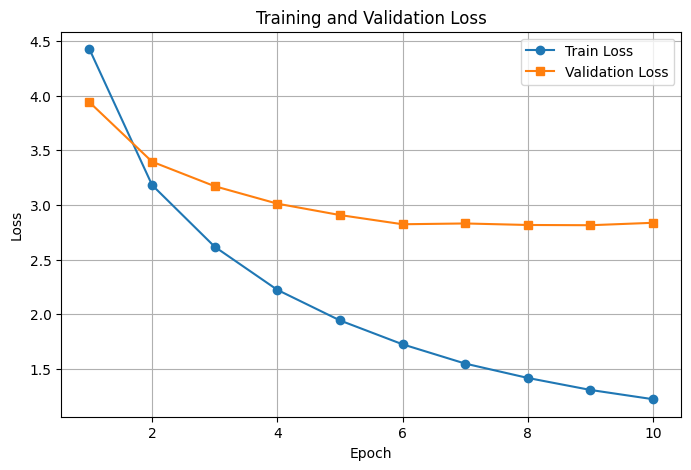

In [93]:
plt.figure(figsize=(8, 5))

plt.plot(range(1, len(train_loss_list) + 1), train_loss_list, label="Train Loss", marker='o')
plt.plot(range(1, len(val_loss_list) + 1), val_loss_list, label="Validation Loss", marker='s')

plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.show()

### 5.2. Xem kết quả dự đoán trên tập test

In [ ]:
model.load_state_dict(torch.load("best_seq2seq_attention.pth", map_location=DEVICE))
model.eval()
smooth_fn = SmoothingFunction().method1

def translate(sentence, beam_size=5, max_len=50, length_alpha=0.7):
    model.eval()

    # Encode
    toks = [SOS_TOK] + tokenize(sentence) + [EOS_TOK]
    src = torch.tensor([[vocab_en[t] for t in toks]],
                       dtype=torch.long, device=DEVICE)
    src_len = torch.tensor([src.size(1)], device=DEVICE)

    with torch.no_grad():
        emb = model.emb_enc(src)
        packed = torch.nn.utils.rnn.pack_padded_sequence(
            emb, src_len.cpu(), batch_first=True, enforce_sorted=False
        )
        enc_packed_out, (h, c) = model.enc(packed)

        enc_out, _ = torch.nn.utils.rnn.pad_packed_sequence(
            enc_packed_out, batch_first=True
        )  # (1, T, H)

        src_mask = (src != PAD_EN).long()  # (1, T)

        # Khởi tạo Beam 
        H = enc_out.size(2)
        context0 = torch.zeros(1, H, device=DEVICE)

        beams = [([SOS_FR], 0.0, h, c, context0)]

        # Decode
        for _ in range(max_len):
            candidates = []

            for seq, score, h_t, c_t, ctx_t in beams:
                last = seq[-1]

                if last == EOS_FR:
                    candidates.append((seq, score, h_t, c_t, ctx_t))
                    continue

                prev = torch.tensor([[last]], device=DEVICE)
                emb_dec = model.emb_dec(prev).squeeze(1)  # (1, E)

                # Input feeding
                dec_input = torch.cat([emb_dec, ctx_t], dim=1)  # (1, E+H)
                dec_input = model.input_feed(dec_input).unsqueeze(1)

                dec_out, (h_new, c_new) = model.dec(dec_input, (h_t, c_t))
                dec_hidden = dec_out.squeeze(1)  # (1, H)

                # Attention
                ctx_new, _ = model.attn(dec_hidden, enc_out, src_mask)

                combined = torch.cat([dec_hidden, ctx_new], dim=1)
                logits = model.out(combined)

                log_probs = torch.log_softmax(logits, dim=-1).squeeze(0)

                # block tokens
                log_probs[PAD_FR] = -1e9
                log_probs[SOS_FR] = -1e9

                topk_vals, topk_idx = torch.topk(log_probs, beam_size)

                for v, idx in zip(topk_vals.tolist(), topk_idx.tolist()):
                    candidates.append(
                        (seq + [idx], score + v, h_new, c_new, ctx_new)
                    )

            # Length normalization
            def norm_score(item):
                s = item[1]
                L = max(1, len(item[0]) - 1)
                return s / (((5 + L) / 6) ** length_alpha)

            beams = sorted(candidates, key=norm_score, reverse=True)[:beam_size]

            if all(b[0][-1] == EOS_FR for b in beams):
                break

        # Best beam
        best_seq = max(beams, key=norm_score)[0]

        out_tokens = []
        for idx in best_seq[1:]:
            if idx == EOS_FR:
                break
            out_tokens.append(vocab_fr.get_itos()[idx])

        return " ".join(out_tokens)

In [98]:
for i in range(min(5, len(test_en_tok))):
    src = " ".join(test_en_tok[i][1:-1])
    ref = test_fr_tok[i][1:-1]
    pred = translate(src, beam_size=5, max_len=60)
    b = sentence_bleu([ref], pred.split(), smoothing_function=smooth_fn)

    print(f"EN: {src}")
    print(f"FR actual: {' '.join(ref)}")
    print(f"FR predicted: {pred}")
    print(f"BLEU: {b:.4f}")
    print("-----------------------")


EN: a young man participates in a career while the subject who records it smiles.
FR actual: un jeune homme participe à une course pendant que le sujet qui le filme sourit.
FR predicted: jeune un jeune homme retire dans une <unk> tandis que tandis que les oiseaux <unk>
BLEU: 0.0743
-----------------------
EN: the man is scratching the back of his neck while looking for a book in a book store.
FR actual: l'homme se gratte l'arrière du cou tout en cherchant un livre dans une librairie.
FR predicted: l'homme l'homme est à l'arrière de son tandis tandis qu'il se un livre dans un magasin faiblement éclairée.
BLEU: 0.0636
-----------------------
EN: a person wearing goggles and a hat is sled riding.
FR actual: une personne portant des lunettes de protection et un chapeau fait de la luge.
FR predicted: personne une personne portant des lunettes et un chapeau est assis.
BLEU: 0.3572
-----------------------
EN: a girl in a pink coat and flowered goloshes sledding down a hill.
FR actual: une fil

### 5.3. Đánh giá BLEU Score và Perplexity trung bình

In [99]:
def evaluate_bleu():
    model.eval()
    total_bleu = 0.0
    count = 0
    for i in range(len(test_en_tok)):
        src = " ".join(test_en_tok[i][1:-1])
        ref = test_fr_tok[i][1:-1]
        hyp = translate(src)

        # nếu translate lỗi, bỏ qua
        if hyp is None:
            continue

        bleu = sentence_bleu([ref], hyp.split(), smoothing_function=smooth)
        total_bleu += bleu
        count += 1

    return total_bleu / max(count, 1)


def evaluate_ppl():
    model.eval()
    total_loss = 0.0
    count = 0

    with torch.no_grad():
        for packed_src, pad_fr, len_en in val_loader:
            packed_src = packed_src.to(DEVICE)
            pad_fr = pad_fr.to(DEVICE)

            logits = model(packed_src, trg=pad_fr, tf_ratio=0.0)

            loss = criterion(
                logits.reshape(-1, logits.size(-1)),
                pad_fr.reshape(-1)
            )

            total_loss += loss.item()
            count += 1

    avg_loss = total_loss / count
    ppl = np.exp(avg_loss)
    return ppl


mean_bleu = evaluate_bleu()
ppl = evaluate_ppl()

print(f"Average BLEU: {mean_bleu:.4f}")
print(f"Average Perplexity: {ppl:.4f}")

Average BLEU: 0.1984
Average Perplexity: 16.6946
